We estimate the FLOPs used by KataGo via iterating through all KataGo training games.

Training games are obtained from:
1. https://katagotraining.org/games/
2. https://katagoarchive.org/kata1/traininggames/index.html
3. https://katagoarchive.org/g170/selfplay/index.html

### Load libraries

In [1]:
import pathlib
import sys

import git.repo
import matplotlib.pyplot as plt
import pandas as pd
import requests
from bs4 import BeautifulSoup
from sgf_parser import game_info
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

# We need to import some libraries from upstream KataGo.
# KataGo doesn't have a setup.py, so we modify sys.path instead (kinda hacky).
GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT / "submodules/KataGo/python"))

### Count distributed training games

In [2]:
def parse_table(table):
    rows = table.find_all("tr")
    header = [th.text.strip() for th in rows[0].find_all("th")]
    data = [[td.text.strip() for td in row.find_all("td")] for row in rows[1:]]
    return pd.DataFrame(data, columns=header)


def parse_network_name(name: str) -> dict[str, int | str]:
    name = name.lstrip("kata1-")
    if name == "random":
        return dict(net_size="random", steps=0, rows=0)

    net_size = name.split("-")[0]
    if net_size.endswith("x2"):
        net_size = net_size.rstrip("x2")

    return dict(
        net_size=net_size,
        steps=int(name.split("-")[1].lstrip("s")),
        rows=int(name.split("-")[2].lstrip("d")),
    )


# Pull data from https://katagotraining.org/games/
r = requests.get("https://katagotraining.org/games/")
soup = BeautifulSoup(r.content, "html.parser")

df = parse_table(soup.find_all("table")[0]).query("Network != 'kata1-random'")

df["n_train"] = (
    df["Training Games"].str.replace(",", "").str.extract(r"(\d+)").astype(int)
)
df["n_rating"] = (
    df["Rating Games"].str.replace(",", "").str.extract(r"(\d+)").astype(int)
)

df_net = pd.DataFrame([parse_network_name(x) for x in df["Network"]])
df = pd.concat([df, df_net], axis=1)

df

,Network,Training Games,Rating Games,n_train,n_rating,net_size,steps,rows
0,kata1-b60c320-s7060499712-d3143549580,"38,383 training games",221 rating games,38383,221,b60c320,7060499712,3143549580
1,kata1-b60c320-s7047906048-d3140270330,"64,590 training games",526 rating games,64590,526,b60c320,7047906048,3140270330
2,kata1-b60c320-s7035181568-d3137113165,"64,317 training games",746 rating games,64317,746,b60c320,7035181568,3137113165
3,kata1-b60c320-s7022594048-d3133696060,"65,420 training games",880 rating games,65420,880,b60c320,7022594048,3133696060
4,kata1-b60c320-s7010139136-d3130207575,"71,912 training games",908 rating games,71912,908,b60c320,7010139136,3130207575
...,...,...,...,...,...,...,...,...
560,kata1-b6c96-s5214720-d1690538,0 training games,"1,816 rating games",0,1816,b6c96,5214720,1690538
561,kata1-b6c96-s4136960-d1510003,0 training games,"1,941 rating games",0,1941,b6c96,4136960,1510003
562,kata1-b6c96-s1995008-d1329786,0 training games,"3,139 rating games",0,3139,b6c96,1995008,1329786
563,kata1-b6c96-s938496-d1208807,0 training games,"5,552 rating games",0,5552,b6c96,938496,1208807


In [3]:
STRONGEST_CONFIDENTLY_RATED_NET = "kata1-b40c256-s11840935168-d2898845681"
LAST_G170_NET = "kata1-b40c256x2-s5095420928-d1229425124"

STRONGEST_CONFIDENTLY_RATED_ROWS = int(
    parse_network_name(STRONGEST_CONFIDENTLY_RATED_NET)["rows"]
)
LAST_G170_ROWS = int(parse_network_name(LAST_G170_NET)["rows"])

cdf = df.query(f"rows < {STRONGEST_CONFIDENTLY_RATED_ROWS} & net_size != 'b60c320'")
print("Distributed training games to reach strongest confidently rated net:")
print(cdf["n_train"].sum(), "training games")
print(cdf["n_rating"].sum(), "rating games")

rows_per_game_train = (STRONGEST_CONFIDENTLY_RATED_ROWS - LAST_G170_ROWS) / cdf[
    "n_train"
].sum()
print()
print("Rows / training game for distributed training:", rows_per_game_train)

print()
print("Total training games assuming constant row/game ratio:")
print(STRONGEST_CONFIDENTLY_RATED_ROWS / rows_per_game_train, "training games")

Distributed training games to reach strongest confidently rated net:
28279595 training games
1437908 rating games

Rows / training game for distributed training: 59.032689718505516

Total training games assuming constant row/game ratio:
49105769.95259751 training games


### Also count g170 games

In [4]:
def count_games_one_file(sgf_path: str) -> dict[str, int | str]:
    """Returns number of games in a single SGF file."""
    with open(sgf_path, "r", encoding="utf-8") as f:
        return dict(
            path=str(sgf_path),
            n_lines=sum(1 for line in f if line.startswith("(;")),
        )


def count_all_games(
    data_dir: str,
    processes: int | None = 128,
    chunksize: int = 32,
) -> pd.DataFrame:
    sgf_paths = game_info.find_sgf_files(root=pathlib.Path(f"{data_dir}"))

    if not processes:
        processes = min(128, len(sgf_paths) // 2)

    rows = process_map(
        count_games_one_file, sgf_paths, max_workers=processes,
        chunksize=chunksize,
        tqdm_class=tqdm,
    )

    return pd.DataFrame(rows)

In [5]:
df_g170 = count_all_games(
    "/nas/ucb/tony/go-attack/katago-data/g170-selfplay-sgfs",
)

100%|██████████| 16114/16114 [00:02<00:00, 6628.52it/s]


In [6]:
# df_g170.path[0].split("/")[-3]
df_g170["net"] = df_g170.path.str.split("/").str[-3]

df_tmp = pd.DataFrame([parse_network_name(x) for x in df_g170.net])
df_g170 = pd.concat([df_g170, df_tmp], axis=1)
df_g170

,path,n_lines,net,net_size,steps,rows
0,/nas/ucb/tony/go-attack/katago-data/g170-selfp...,534,b30c320x2-s2764354304-d813874270,b30c320,2764354304,813874270
1,/nas/ucb/tony/go-attack/katago-data/g170-selfp...,525,b30c320x2-s2764354304-d813874270,b30c320,2764354304,813874270
2,/nas/ucb/tony/go-attack/katago-data/g170-selfp...,519,b30c320x2-s2764354304-d813874270,b30c320,2764354304,813874270
3,/nas/ucb/tony/go-attack/katago-data/g170-selfp...,511,b30c320x2-s2764354304-d813874270,b30c320,2764354304,813874270
4,/nas/ucb/tony/go-attack/katago-data/g170-selfp...,535,b30c320x2-s2764354304-d813874270,b30c320,2764354304,813874270
...,...,...,...,...,...,...
16109,/nas/ucb/tony/go-attack/katago-data/g170-selfp...,685,b30c320x2-s3143926528-d889658247,b30c320,3143926528,889658247
16110,/nas/ucb/tony/go-attack/katago-data/g170-selfp...,695,b30c320x2-s3143926528-d889658247,b30c320,3143926528,889658247
16111,/nas/ucb/tony/go-attack/katago-data/g170-selfp...,684,b30c320x2-s3143926528-d889658247,b30c320,3143926528,889658247
16112,/nas/ucb/tony/go-attack/katago-data/g170-selfp...,697,b30c320x2-s3143926528-d889658247,b30c320,3143926528,889658247


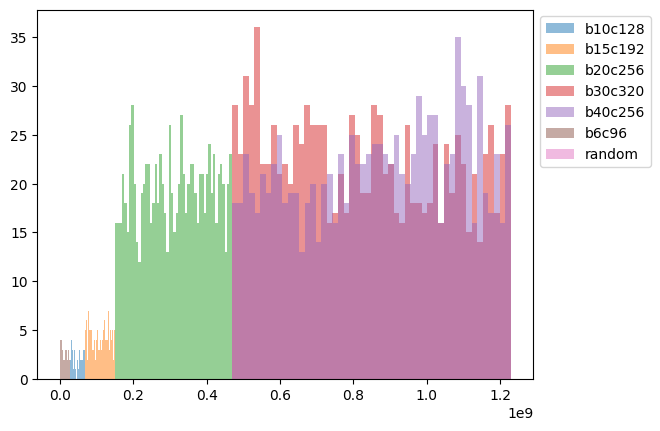

In [7]:
cdf = df_g170.groupby(["net_size", "rows"]).n_lines.sum()

for net_size in cdf.index.levels[0]:
    plt.hist(cdf.loc[net_size].index.values, bins=50, label=net_size, alpha=0.5);

# Legend on outside right
plt.legend(bbox_to_anchor=(1, 1), loc="upper left");

In [8]:
g170_games = df_g170.n_lines.sum()
distributed_games = df.query(f"rows < {STRONGEST_CONFIDENTLY_RATED_ROWS} & net_size != 'b60c320'").n_train.sum()

print("Total games to get Latest:", g170_games + distributed_games)

Total games to get Latest: 53123109
